<h1>Prompt Engineering</h1>

In [ ]:
# %%capture
# !pip install langchain>=0.1.17 openai>=1.13.3 langchain_openai>=0.1.6 transformers>=4.40.1 datasets>=2.18.0 accelerate>=0.27.2 sentence-transformers>=2.5.1 duckduckgo-search>=5.2.2
# !CMAKE_ARGS="-DLLAMA_CUBLAS=on" pip install llama-cpp-python

## Loading our model

In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline

# Load model and tokenizer
model = AutoModelForCausalLM.from_pretrained(
    "microsoft/Phi-3-mini-4k-instruct",
    device_map="cuda",
    torch_dtype="auto",
    trust_remote_code=True,
)
tokenizer = AutoTokenizer.from_pretrained("microsoft/Phi-3-mini-4k-instruct")

# Create a pipeline
pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    return_full_text=False,
    max_new_tokens=500,
    do_sample=False,
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
# Prompt
messages = [
    {"role": "user", "content": "Create a funny joke about chickens."}
]

# Generate the output
output = pipe(messages)
print(output[0]["generated_text"])

 Why don't chickens like to go to the gym? Because they can't crack the egg-sistence of it!


In [ ]:
# Apply prompt template
prompt = pipe.tokenizer.apply_chat_template(messages, tokenize=False)
print(prompt)

<s><|user|>
Create a funny joke about chickens.<|end|>
<|assistant|>



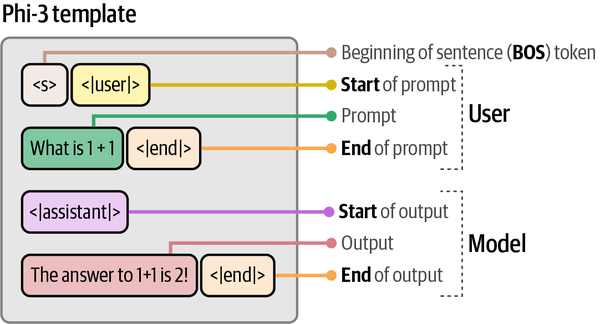

In [ ]:
# Using a high temperature
output = pipe(messages, do_sample=True, temperature=1)
print(output[0]["generated_text"])

 Why don't chickens ever play hide and seek? Because good luck hiding when everyone always goes to the henhouse!


In [ ]:
# Using a high top_p
output = pipe(messages, do_sample=True, top_p=1)
print(output[0]["generated_text"])

 Why don't chickens like math class? Because they can't solve for "x" in their eggs!


# **Advanced Prompt Engineering**


## Complex Prompt

In [ ]:
text = """In the previous post, we looked at Attention – a ubiquitous method in modern deep learning models. Attention is a concept that helped improve the performance of neural machine translation applications. In this post, we will look at The Transformer – a model that uses attention to boost the speed with which these models can be trained. The Transformer outperforms the Google Neural Machine Translation model in specific tasks. The biggest benefit, however, comes from how The Transformer lends itself to parallelization. It is in fact Google Cloud’s recommendation to use The Transformer as a reference model to use their Cloud TPU offering. So let’s try to break the model apart and look at how it functions.
The Transformer was proposed in the paper Attention is All You Need. A TensorFlow implementation of it is available as a part of the Tensor2Tensor package. Harvard’s NLP group created a guide annotating the paper with PyTorch implementation. In this post, we will attempt to oversimplify things a bit and introduce the concepts one by one to hopefully make it easier to understand to people without in-depth knowledge of the subject matter.
Let’s begin by looking at the model as a single black box. In a machine translation application, it would take a sentence in one language, and output its translation in another.
Popping open that Optimus Prime goodness, we see an encoding component, a decoding component, and connections between them.
The encoding component is a stack of encoders (the paper stacks six of them on top of each other – there’s nothing magical about the number six, one can definitely experiment with other arrangements). The decoding component is a stack of decoders of the same number.
The encoders are all identical in structure (yet they do not share weights). Each one is broken down into two sub-layers:
The encoder’s inputs first flow through a self-attention layer – a layer that helps the encoder look at other words in the input sentence as it encodes a specific word. We’ll look closer at self-attention later in the post.
The outputs of the self-attention layer are fed to a feed-forward neural network. The exact same feed-forward network is independently applied to each position.
The decoder has both those layers, but between them is an attention layer that helps the decoder focus on relevant parts of the input sentence (similar what attention does in seq2seq models).
Now that we’ve seen the major components of the model, let’s start to look at the various vectors/tensors and how they flow between these components to turn the input of a trained model into an output.
As is the case in NLP applications in general, we begin by turning each input word into a vector using an embedding algorithm.
Each word is embedded into a vector of size 512. We'll represent those vectors with these simple boxes.
The embedding only happens in the bottom-most encoder. The abstraction that is common to all the encoders is that they receive a list of vectors each of the size 512 – In the bottom encoder that would be the word embeddings, but in other encoders, it would be the output of the encoder that’s directly below. The size of this list is hyperparameter we can set – basically it would be the length of the longest sentence in our training dataset.
After embedding the words in our input sequence, each of them flows through each of the two layers of the encoder.
Here we begin to see one key property of the Transformer, which is that the word in each position flows through its own path in the encoder. There are dependencies between these paths in the self-attention layer. The feed-forward layer does not have those dependencies, however, and thus the various paths can be executed in parallel while flowing through the feed-forward layer.
Next, we’ll switch up the example to a shorter sentence and we’ll look at what happens in each sub-layer of the encoder.
Now We’re Encoding!
As we’ve mentioned already, an encoder receives a list of vectors as input. It processes this list by passing these vectors into a ‘self-attention’ layer, then into a feed-forward neural network, then sends out the output upwards to the next encoder.
"""

# Prompt components
persona = "You are an expert in Large Language models. You excel at breaking down complex papers into digestible summaries.\n"
instruction = "Summarize the key findings of the paper provided.\n"
context = "Your summary should extract the most crucial points that can help researchers quickly understand the most vital information of the paper.\n"
data_format = "Create a bullet-point summary that outlines the method. Follow this up with a concise paragraph that encapsulates the main results.\n"
audience = "The summary is designed for busy researchers that quickly need to grasp the newest trends in Large Language Models.\n"
tone = "The tone should be professional and clear.\n"
text = "MY TEXT TO SUMMARIZE"  # Replace with your own text to summarize
data = f"Text to summarize: {text}"

query = persona + instruction + context + data_format + audience + tone + data

In [ ]:
messages = [
    {"role": "user", "content": query}
]
print(tokenizer.apply_chat_template(messages, tokenize=False))

<s><|user|>
You are an expert in Large Language models. You excel at breaking down complex papers into digestible summaries.
Summarize the key findings of the paper provided.
Your summary should extract the most crucial points that can help researchers quickly understand the most vital information of the paper.
Create a bullet-point summary that outlines the method. Follow this up with a concise paragraph that encapsulates the main results.
The summary is designed for busy researchers that quickly need to grasp the newest trends in Large Language Models.
The tone should be professional and clear.
Text to summarize: MY TEXT TO SUMMARIZE<|end|>
<|assistant|>



In [ ]:
# Generate the output
outputs = pipe(messages)
print(outputs[0]["generated_text"])

 Key Findings:

- The Transformer model utilizes attention mechanisms to improve the speed and performance of deep learning models, particularly in neural machine translation tasks.
- It outperforms the Google Neural Machine Translation model in specific tasks and is recommended by Google Cloud for their Cloud TPU offering.
- The Transformer model consists of an encoding component and a decoding component, both composed of stacks of identical encoders and decoders.
- The encoders use self-attention layers to process input sequences, while the decoders incorporate attention layers to focus on relevant parts of the input.
- The model employs embedding algorithms to convert input words into vectors of size 512, which are then processed through the encoder's layers.
- The Transformer model's architecture allows for parallelization, enabling faster training and improved performance.

Summary:

- The Transformer model, introduced in the paper "Attention is All You Need," revolutionizes deep 

## In-Context Learning

In [ ]:
# Use a single example of using the made-up word in a sentence
one_shot_prompt = [
    {
        "role": "user",
        "content": "A 'Gigamuru' is a type of Japanese musical instrument. An example of a sentence that uses the word Gigamuru is:"
    },
    {
        "role": "assistant",
        "content": "I have a Gigamuru that my uncle gave me as a gift. I love to play it at home."
    },
    {
        "role": "user",
        "content": "To 'screeg' something is to swing a sword at it. An example of a sentence that uses the word screeg is:"
    }
]
print(tokenizer.apply_chat_template(one_shot_prompt, tokenize=False))

<s><|user|>
A 'Gigamuru' is a type of Japanese musical instrument. An example of a sentence that uses the word Gigamuru is:<|end|>
<|assistant|>
I have a Gigamuru that my uncle gave me as a gift. I love to play it at home.<|end|>
<|user|>
To 'screeg' something is to swing a sword at it. An example of a sentence that uses the word screeg is:<|end|>
<|assistant|>



In [ ]:
# Generate the output
outputs = pipe(one_shot_prompt)
print(outputs[0]["generated_text"])

 During the intense duel, the knight skillfully screeged his opponent's shield, forcing him to defend himself.


## Chain Prompting


In [ ]:
# Create name and slogan for a product
product_prompt = [
    {"role": "user", "content": "Create a name and slogan for a chatbot that leverages LLMs."}
]
outputs = pipe(product_prompt)
product_description = outputs[0]["generated_text"]
print(product_description)

 Name: "MindMeld Messenger"

Slogan: "Unleashing Intelligent Conversations, One Response at a Time"


In [ ]:
# Based on a name and slogan for a product, generate a sales pitch
sales_prompt = [
    {"role": "user", "content": f"Generate a very short sales pitch for the following product: '{product_description}'"}
]
outputs = pipe(sales_prompt)
sales_pitch = outputs[0]["generated_text"]
print(sales_pitch)

 Introducing MindMeld Messenger - your ultimate communication partner! Unleash intelligent conversations with our innovative AI-powered messaging platform. With MindMeld Messenger, every response is thoughtful, personalized, and timely. Say goodbye to generic replies and hello to meaningful interactions. Elevate your communication game with MindMeld Messenger - where every message is a step towards smarter conversations. Try it now and experience the future of messaging!


# **Reasoning with Generative Models**


## Chain-of-Thought: Think Before Answering


In [ ]:
# # Answering without explicit reasoning
# standard_prompt = [
#     {"role": "user", "content": "Roger has 5 tennis balls. He buys 2 more cans of tennis balls. Each can has 3 tennis balls. How many tennis balls does he have now?"},
#     {"role": "assistant", "content": "11"},
#     {"role": "user", "content": "The cafeteria had 25 apples. If they used 20 to make lunch and bought 6 more, how many apples do they have?"}
# ]

# # Run generative model
# outputs = pipe(standard_prompt)
# print(outputs[0]["generated_text"])

 The cafeteria started with 25 apples. They used 20 apples to make lunch, so they had:

25 - 20 = 5 apples left.

Then they bought 6 more apples, so they now have:

5 + 6 = 11 apples.


In [ ]:
# Answering with chain-of-thought
cot_prompt = [
    {"role": "user", "content": "Roger has 5 tennis balls. He buys 2 more cans of tennis balls. Each can has 3 tennis balls. How many tennis balls does he have now?"},
    {"role": "assistant", "content": "Roger started with 5 balls. 2 cans of 3 tennis balls each is 6 tennis balls. 5 + 6 = 11. The answer is 11."},
    {"role": "user", "content": "The cafeteria had 23 apples. If they used 20 to make lunch and bought 6 more, how many apples do they have?"}
]

# Generate the output
outputs = pipe(cot_prompt)
print(outputs[0]["generated_text"])

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


 The cafeteria started with 23 apples. They used 20 apples, so they had 23 - 20 = 3 apples left. Then they bought 6 more apples, so they now have 3 + 6 = 9 apples. The answer is 9.


## Zero-shot Chain-of-Thought


In [ ]:
# Zero-shot Chain-of-Thought
zeroshot_cot_prompt = [
    {"role": "user", "content": "The cafeteria had 23 apples. If they used 20 to make lunch and bought 6 more, how many apples do they have? Let's think step-by-step."}
]

# Generate the output
outputs = pipe(zeroshot_cot_prompt)
print(outputs[0]["generated_text"])

 Step 1: Start with the initial number of apples, which is 23.
Step 2: Subtract the number of apples used to make lunch, which is 20. So, 23 - 20 = 3 apples remaining.
Step 3: Add the number of apples bought, which is 6. So, 3 + 6 = 9 apples.

The cafeteria now has 9 apples.


## Tree-of-Thought: Exploring Intermediate Steps


In [ ]:
# Zero-shot Chain-of-Thought
zeroshot_tot_prompt = [
    {"role": "user", "content": "Imagine three different experts are answering this question. All experts will write down 1 step of their thinking, then share it with the group. Then all experts will go on to the next step, etc. If any expert realises they're wrong at any point then they leave. The question is 'The cafeteria had 23 apples. If they used 20 to make lunch and bought 6 more, how many apples do they have?' Make sure to discuss the results."}
]

In [ ]:
# Generate the output
outputs = pipe(zeroshot_tot_prompt)
print(outputs[0]["generated_text"])

 Expert 1: Step 1 - Start with the initial number of apples: 23 apples.

Expert 2: Step 1 - Subtract the apples used for lunch: 23 - 20 = 3 apples remaining.

Expert 3: Step 1 - Add the newly bought apples: 3 + 6 = 9 apples.


Expert 1: Step 2 - Confirm the final count: The cafeteria has 9 apples.

Expert 2: Step 2 - Review the calculations: 23 - 20 = 3, then 3 + 6 = 9. The calculations are correct.

Expert 3: Step 2 - Agree with the result: The cafeteria indeed has 9 apples.


All experts agree on the final count: The cafeteria has 9 apples.


# **Output Verification**

In [ ]:
# Zero-shot learning: Providing no examples
zeroshot_prompt = [
    {"role": "user", "content": "Create a character profile for an RPG game in JSON format."}
]

# Generate the output
outputs = pipe(zeroshot_prompt)
print(outputs[0]["generated_text"])

 {
  "character_profile": {
    "name": "Eldrin Stormbringer",
    "race": "Human",
    "class": "Warlock",
    "level": 5,
    "alignment": "Chaotic Good",
    "attributes": {
      "strength": 8,
      "dexterity": 14,
      "constitution": 10,
      "intelligence": 12,
      "wisdom": 10,
      "charisma": 16
    },
    "skills": [
      {
        "name": "Fireball",
        "proficiency": 18
      },
      {
        "name": "Shadowstep",
        "proficiency": 16
      },
      {
        "name": "Charm Person",
        "proficiency": 14
      }
    ],
    "equipment": [
      {
        "name": "Stormbringer Staff",
        "type": "Magic Weapon",
        "damage": 15
      },
      {
        "name": "Leather Armor",
        "type": "Light Armor",
        "defense": 10
      },
      {
        "name": "Ring of Protection",
        "type": "Magic Armor",
        "defense": 5
      }
    ],
    "background": "Eldrin grew up in a small village, where he was known for his mischievous na

In [ ]:
# One-shot learning: Providing an example of the output structure
one_shot_template = """Create a short character profile for an RPG game. Make sure to only use this format:

{
  "description": "A SHORT DESCRIPTION",
  "name": "THE CHARACTER'S NAME",
  "armor": "ONE PIECE OF ARMOR",
  "weapon": "ONE OR MORE WEAPONS"
}
"""
one_shot_prompt = [
    {"role": "user", "content": one_shot_template}
]

# Generate the output
outputs = pipe(one_shot_prompt)
print(outputs[0]["generated_text"])

 {
  "description": "A cunning rogue with a mysterious past, skilled in stealth and deception.",
  "name": "Lysandra Shadowstep",
  "armor": "Leather Cloak of the Night",
  "weapon": "Dagger of Whispers, Throwing Knives"
}


## Grammar: Constrained Sampling


In [ ]:
import gc
import torch
del model, tokenizer, pipe

# Flush memory
gc.collect()
torch.cuda.empty_cache()

In [ ]:
from llama_cpp.llama import Llama

# Load Phi-3
llm = Llama.from_pretrained(
    repo_id="microsoft/Phi-3-mini-4k-instruct-gguf",
    filename="*fp16.gguf",
    n_gpu_layers=-1,
    n_ctx=2048,
    verbose=False
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
# Generate output
output = llm.create_chat_completion(
    messages=[
        {"role": "user", "content": "Create a warrior for an RPG in JSON format."},
    ],
    response_format={"type": "json_object"},
    temperature=0,
)['choices'][0]['message']["content"]


In [ ]:
import json

# Format as json
json_output = json.dumps(json.loads(output), indent=4)
print(json_output)

{
    "name": "Eldrin Stormbringer",
    "class": "Ranger",
    "level": 5,
    "attributes": {
        "strength": 14,
        "dexterity": 18,
        "constitution": 12,
        "intelligence": 10,
        "wisdom": 13,
        "charisma": 9
    },
    "skills": {
        "archery": {
            "proficiency": 20,
            "critical_hit_chance": 5,
            "damage_range": [
                8,
                14
            ]
        },
        "stealth": {
            "proficiency": 17,
            "critical_hit_chance": 3,
            "damage_range": [
                2,
                6
            ]
        },
        "nature_magic": {
            "proficiency": 15,
            "critical_hit_chance": 4,
            "healing_range": [
                3,
                7
            ],
            "damage_range": [
                -2,
                2
            ]
        }
    },
    "equipment": {
        "weapons": [
            "Longbow",
            "Dagger"
      